In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
# leer archivo CSV

strava_hugo = pd.read_csv(r"C:\Users\eduar\OneDrive\Escritorio\Master_DataScience_AI\TFM. “Predicción del rendimiento en corredores mediante técnicas de Machine Learning un enfoque aplicado al sector deportivo”\data\activities_hugo_magallón.csv")

# mostrar las primeras filas del DataFrame

strava_hugo.head()


,ID de actividad,Fecha de la actividad,Nombre de la actividad,Tipo de actividad,Descripción de la actividad,Tiempo transcurrido,Distancia,Ritmo cardiaco máximo,Esfuerzo Relativo,Desplazamiento,...,Intensidad,Ritmo ajustado en pendientes promedio,Tiempo cronometrado,Ciclos en total,Recuperación,Con mascota,Competición,Carrera de larga distancia,Por una causa,Multimedia
0,12686857640,18 oct. 2024 17:39:05,Carrera de noche,Carrera,NaN,1596,"3,96",NaN,NaN,False,...,NaN,2.529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12711351481,21 oct. 2024 18:50:07,Carrera nocturna,Carrera,NaN,1956,"5,05",NaN,NaN,False,...,NaN,2.623,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12743223647,25 oct. 2024 17:48:27,Carrera de noche,Carrera,NaN,2701,"7,00",NaN,NaN,False,...,NaN,2.635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12766711836,28 oct. 2024 16:40:08,Carrera de noche,Carrera,NaN,2946,"8,00",NaN,NaN,False,...,NaN,2.727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12783156257,30 oct. 2024 16:47:31,Carrera de noche,Carrera,NaN,2579,"7,20",NaN,NaN,False,...,NaN,2.796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# variable distancia a float
strava_hugo['Distancia'] = strava_hugo['Distancia'].replace(',', '.', regex=True).astype(float)

In [4]:
strava_hugo.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 99 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   ID de actividad                                        146 non-null    int64  
 1   Fecha de la actividad                                  146 non-null    object 
 2   Nombre de la actividad                                 146 non-null    object 
 3   Tipo de actividad                                      146 non-null    object 
 4   Descripción de la actividad                            23 non-null     object 
 5   Tiempo transcurrido                                    146 non-null    int64  
 6   Distancia                                              146 non-null    float64
 7   Ritmo cardiaco máximo                                  119 non-null    float64
 8   Esfuerzo Relativo                                 

In [5]:
def limpiar_strava(df):
    # Renombrar columnas para facilitar el manejo
    df = df.rename(columns={
        'Fecha de la actividad': 'activity_date',
        'Tipo de actividad': 'activity_type',
        'Nombre de la actividad': 'activity_name',
        'Distancia': 'distance',
        'Tiempo transcurrido': 'elapsed_time',
        'Velocidad promedio': 'average_speed',
        'Desnivel positivo': 'elevation_gain',
        'Ritmo cardiaco promedio': 'avg_heart_rate',
        'Ritmo cardiaco máximo': 'max_heart_rate',
        'Calorías': 'calories',
        'Cadencia promedio': 'avg_cadence',
        'ID de actividad': 'activity_id',
    })

    # Convertir activity_date a datetime
    df['activity_date'] = pd.to_datetime(df['activity_date'], errors='coerce')
    df = df[(df['activity_date'].dt.year >= 2024) & (df['activity_type'] == 'Carrera')]

    if df['distance'].max() > 1000:
        df['distance_km'] = df['distance'] / 1000
    else:
        df['distance_km'] = df['distance']

    # Calcular el ritmo promedio en segundos por km
    df['avg_pace_s_per_km'] = df['elapsed_time'] / df['distance_km']

    # Calcular el ritmo en minutos por km
    df['minutes_per_km'] = df['avg_pace_s_per_km'] / 60

    # Función simple para formatear ritmo
    def format_pace(minutes_per_km):
        if pd.isna(minutes_per_km) or minutes_per_km <= 0:
            return "N/A"
        minutes = int(minutes_per_km)
        seconds = int(round((minutes_per_km - minutes) * 60))
        if seconds == 60:
            minutes += 1
            seconds = 0
        return f"{minutes}.{seconds:02d}"

    # Aplicar formato de ritmo
    df['pace_formatted'] = df['minutes_per_km'].apply(format_pace)
    # cambiarla a float
    df['pace_formatted'] = df['pace_formatted'].replace("N/A", np.nan).astype(float)

    # Nueva columna: elapsed_time en formato hh:mm:ss (sin días)
    df['elapsed_time_hms'] = pd.to_timedelta(df['elapsed_time'], unit='s').apply(lambda x: f"{int(x.total_seconds() // 3600):02}:{int((x.total_seconds() % 3600) // 60):02}:{int(x.total_seconds() % 60):02}")

    # Seleccionar solo las columnas relevantes
    columnas = [
        'activity_id', 'activity_date', 'activity_type',
        'distance_km','elapsed_time_hms',
        'pace_formatted','elevation_gain', 'avg_cadence','avg_heart_rate', 'max_heart_rate', 'calories'
    ]
    df = df[columnas]

    return df

strava_limpio = limpiar_strava(strava_hugo)

C:\Users\eduar\AppData\Local\Temp\ipykernel_38168\1094728652.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['activity_date'] = pd.to_datetime(df['activity_date'], errors='coerce')


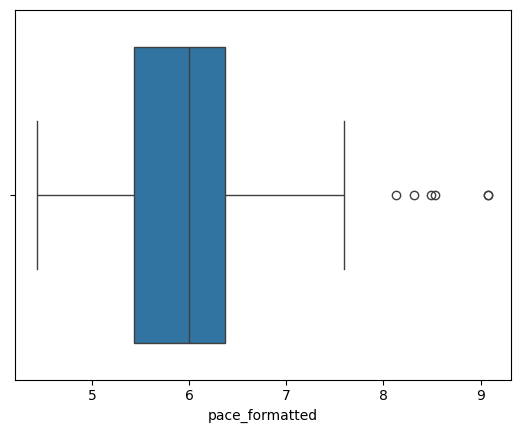

In [6]:
# ver outliers en pace_formatted
sns.boxplot(x=strava_limpio['pace_formatted'])
plt.show()

In [7]:
# añadir columna usuario

strava_limpio['user'] = 'Hugo Magallón Causapé'

In [8]:
# mostrar las ultimas filas del DataFrame limpio

strava_limpio.tail()

,activity_id,activity_date,activity_type,distance_km,elapsed_time_hms,pace_formatted,elevation_gain,avg_cadence,avg_heart_rate,max_heart_rate,calories,user
141,15661172408,2025-09-01 15:57:55,Carrera,7.0,00:50:26,7.12,6.4,76.0,183.0,199.0,550.0,Hugo Magallón Causapé
142,15672785768,2025-09-02 16:09:31,Carrera,5.0,00:31:07,6.13,13.7,74.0,175.0,193.0,425.0,Hugo Magallón Causapé
143,15718697553,2025-09-06 14:49:34,Carrera,6.0,00:45:27,7.35,11.8,75.0,182.0,197.0,509.0,Hugo Magallón Causapé
144,15755348873,2025-09-09 18:02:47,Carrera,3.3,00:20:53,6.20,4.2,74.0,169.0,199.0,254.0,Hugo Magallón Causapé
145,15766095246,2025-09-10 16:22:37,Carrera,6.0,00:40:31,6.45,10.9,75.0,180.0,203.0,470.0,Hugo Magallón Causapé


In [9]:
# Guardar el DataFrame limpio en la carpeta csv_clean
strava_limpio.to_csv(r"C:\Users\eduar\OneDrive\Escritorio\Master_DataScience_AI\TFM. “Predicción del rendimiento en corredores mediante técnicas de Machine Learning un enfoque aplicado al sector deportivo”\csv_clean\strava_hugo_magallon_limpio.csv", index=False)

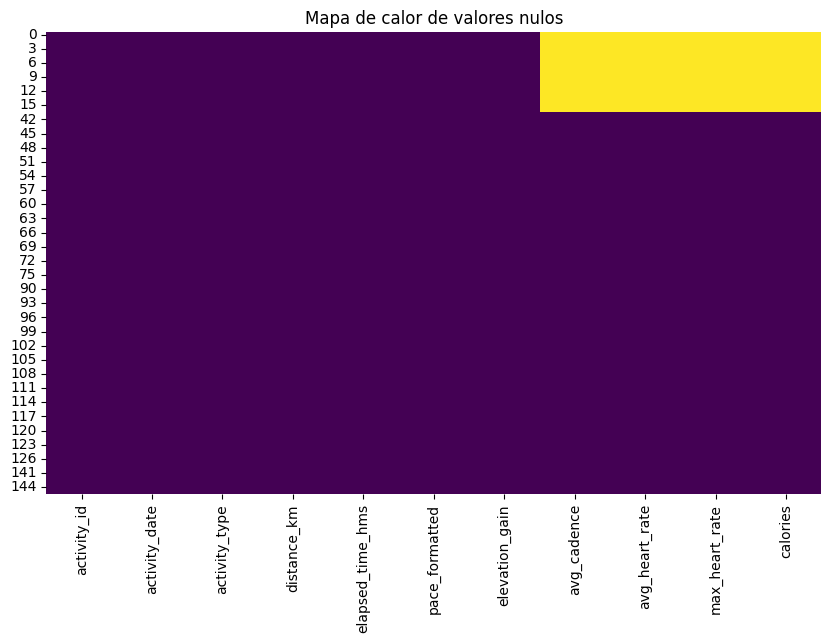

Estadísticos de variables seleccionadas:
       distance_km  pace_formatted     calories
count    98.000000       98.000000    81.000000
mean      6.159286        6.067653   485.876543
std       2.549888        0.916634   232.917656
min       2.090000        4.440000   183.000000
25%       4.490000        5.430000   342.000000
50%       6.000000        6.005000   451.000000
75%       7.010000        6.372500   554.000000
max      16.000000        9.080000  1391.000000


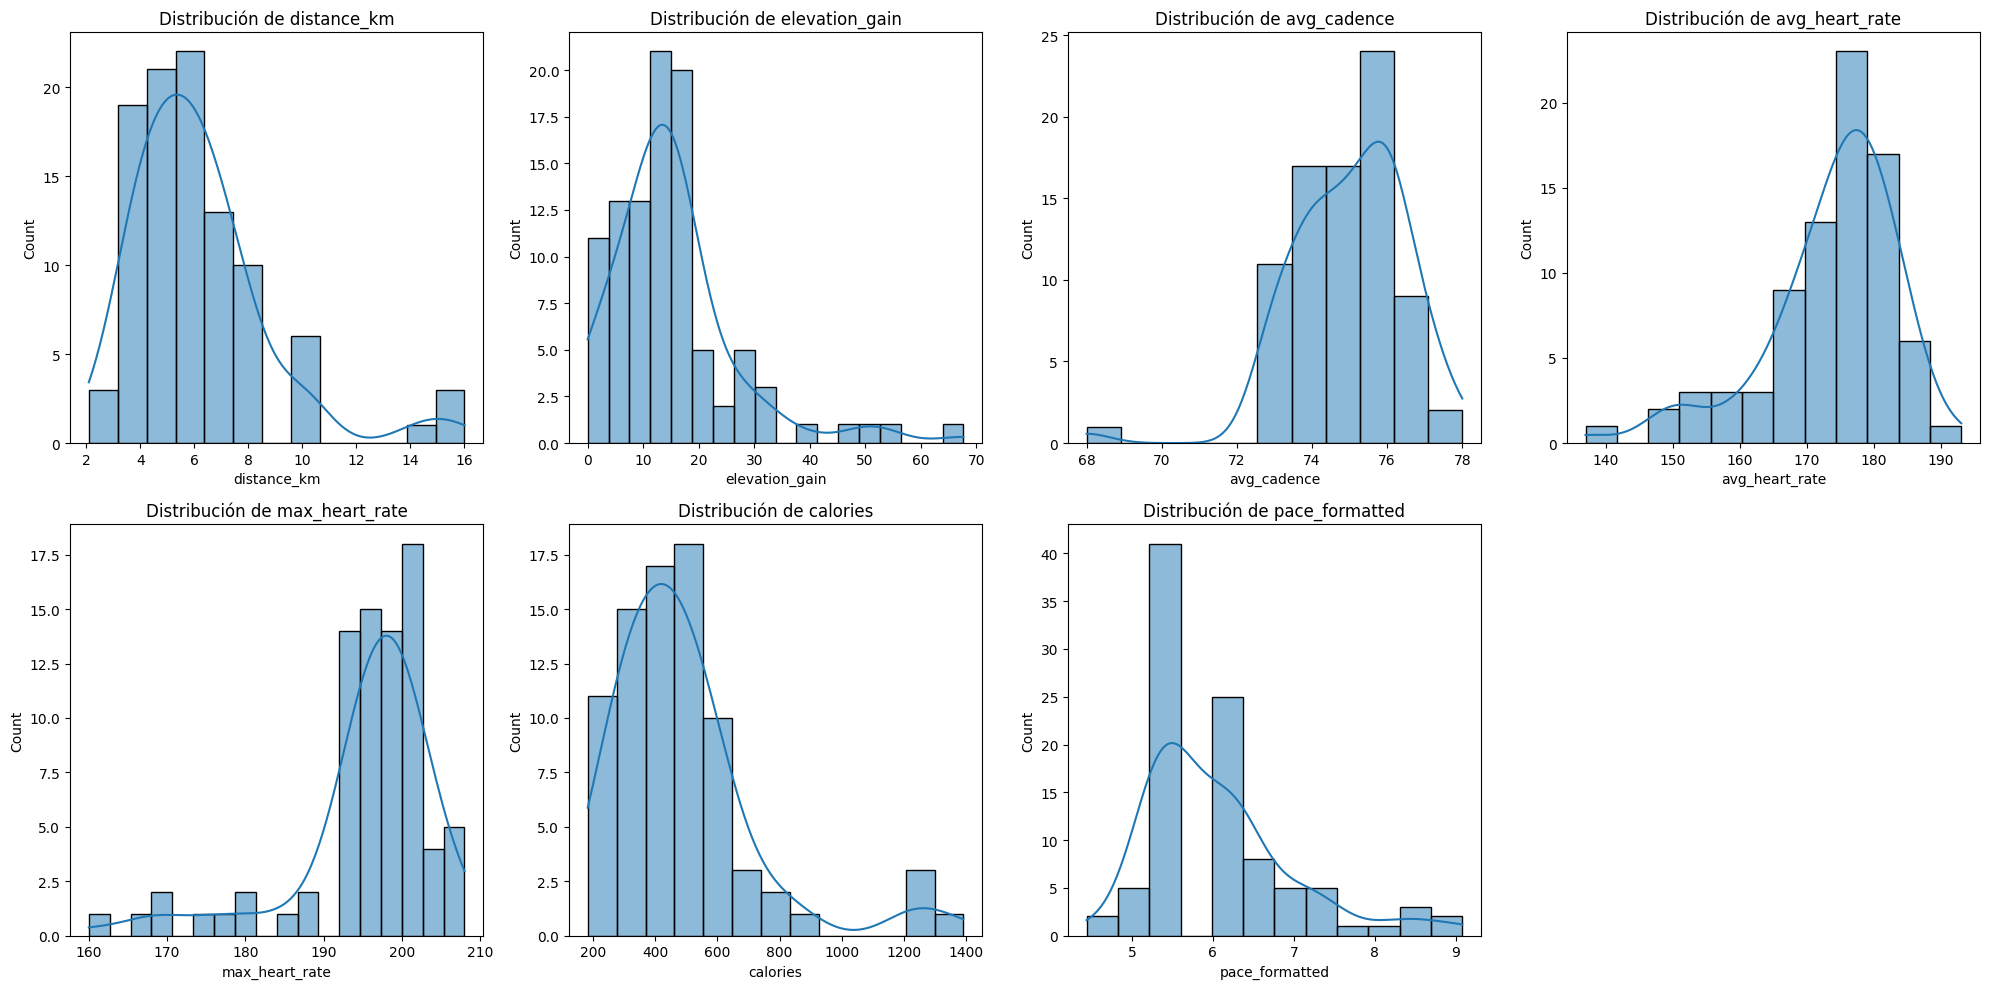

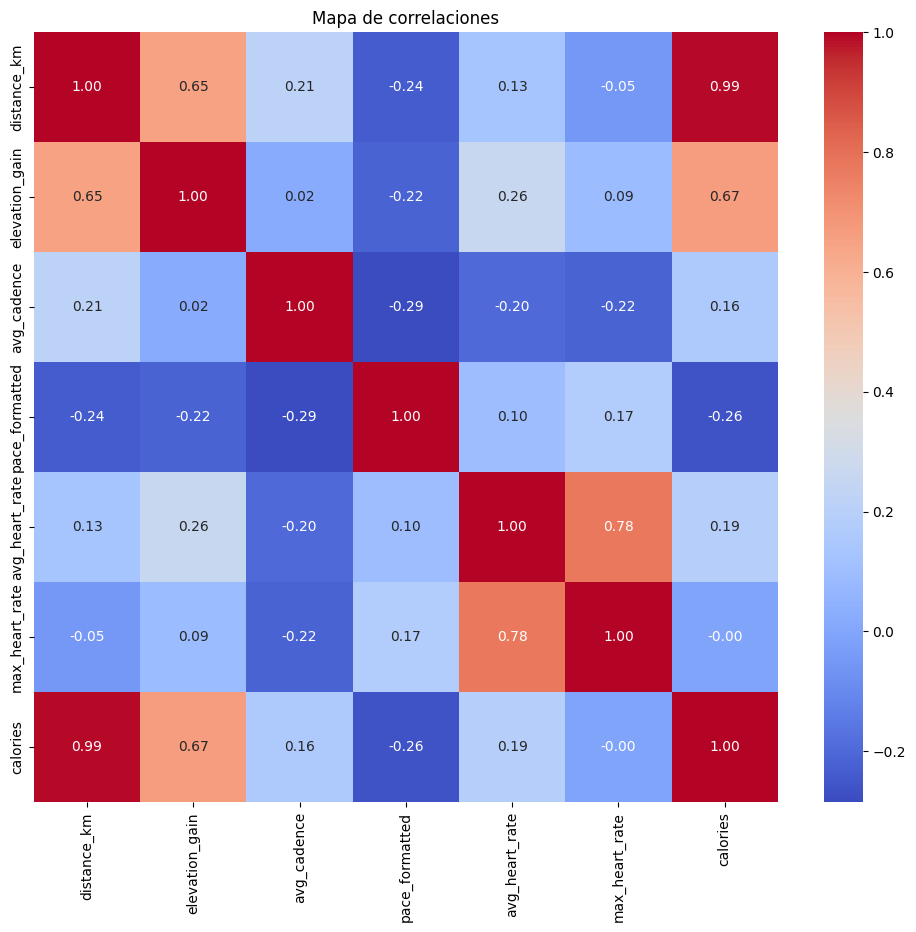

In [10]:
def EDA(data):
    # Seleccionar solo las columnas relevantes
    columnas = [
        'activity_id', 'activity_date', 'activity_type',
        'distance_km', 'elapsed_time_hms',
        'pace_formatted', 'elevation_gain', 'avg_cadence',
        'avg_heart_rate', 'max_heart_rate', 'calories'
    ]
    data = data[columnas]

    # Gráficos para ver nulos
    if data.isnull().sum().sum() == 0:
        print("No hay valores nulos en las variables seleccionadas.")
    else:
        plt.figure(figsize=(10,6))
        sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
        plt.title('Mapa de calor de valores nulos')
        plt.show()

    # Estadísticos de variables seleccionadas
    print("Estadísticos de variables seleccionadas:")
    print(data[['distance_km', 'pace_formatted', 'calories']].describe())

    # Distribución de variables continuas en una sola imagen
    dist_vars = ['distance_km', 'elevation_gain', 'avg_cadence', 'avg_heart_rate', 'max_heart_rate', 'calories', 'pace_formatted']
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
    axes = axes.flatten()

    for i, var in enumerate(dist_vars):
        if i < len(axes):
            ax = axes[i]
            if data[var].dtype == 'object':
                data[var].value_counts().plot(kind='bar', ax=ax)
                ax.set_ylabel('Frecuencia')
            else:
                sns.histplot(data[var].dropna(), kde=True, ax=ax)
            ax.set_title(f'Distribución de {var}')

    # Eliminar el subplot vacío si hay menos variables que subplots
    for j in range(len(dist_vars), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    # Mapa de correlaciones (todas las variables numéricas relevantes)
    plt.figure(figsize=(12,10))
    corr_vars = ['distance_km', 'elevation_gain', 'avg_cadence','pace_formatted', 'avg_heart_rate', 'max_heart_rate', 'calories']
    corr = data[corr_vars].corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Mapa de correlaciones')
    plt.show()

EDA(strava_limpio)
